# PW1 - Handwritten character recognition


In [121]:
# Write your name here (e.g. "Edmond Dantès") so I can grade your work
your_name = "Lucas Lateb"
assert your_name

In [122]:
%matplotlib inline
import math, sys, os, torch, torchvision
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [123]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


We will be training many models. Select a number of epochs to train each model. If you are using a slow machine, or if you want to restart training often and have many development iterations, we suggest `NUM_EPOCH = 2`. If you are using a fast machine, or have a GPU available, of if you are confident that you can write accurate code first try, you will get better accuracies by increasing this constant. You could be able to afford up to `NUM_EPOCH = 10`.

In [124]:
NUM_EPOCH = 2

# Part A - Linear, MLP, and CNN


## Handwritten digit recognition dataset

We will use the MNIST database (Modified National Institute of Standards and Technology database). It contains tens of thousands of pictures of handwritten digits. This database was compiled in 1994, as part of the effort in the 1990s to standardize automation of sorting devices with human input, for instance sorting mail with handwritten postal codes at the post office. This is now often considered one of the first real successes of neural networks, and the first easy example on which performance of new such algorithms is tested.

Load the dataset (train and test splits) using `torchvision`

In [125]:
root_dir = './data/MNIST/'

### YOUR CODE HERE ###

from torchvision import datasets, transforms

# Define transformations for the dataset
transform = transforms.Compose([transforms.ToTensor()])

# Load the training and test datasets
train_dataset = datasets.MNIST(root=root_dir, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=root_dir, train=False, transform=transform, download=True)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [126]:
train_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data/MNIST/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data/MNIST/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

How many examples in each split? 

Plot the first image and label of the training set using `matplotlib`

What is the input dimension?

In [127]:
# Number of examples in each split
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of test examples: {len(test_dataset)}")

Number of training examples: 60000
Number of test examples: 10000


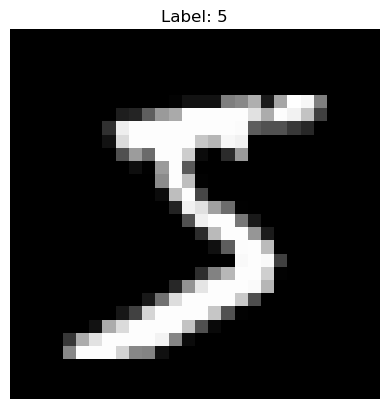

In [128]:
# Plot the first image and label of the training set
first_image, first_label = train_dataset[0]
plt.imshow(first_image.squeeze(), cmap="gray")
plt.title(f"Label: {first_label}")
plt.axis("off")
plt.show()

In [129]:
# Input dimension
print(f"Input dimension: {first_image.shape}")

Input dimension: torch.Size([1, 28, 28])


# A.1 - Linear features

We start with a very simple model, linear with respect to pixel values.
Use a `preprocess` function to downsample the image to 7x7 pixels, then flatten it and use a `torch.nn.Linear` model.

The torch average-pooling function is `torch.nn.functional.avg_pool2d`, check the documentation to set the arguments properly.
DO NOT use your implementation of average-pooling, it would take prohibitively long to train and you would not finish the practical.
If the training takes too long, go back to the first section and lower the `NUM_EPOCH` constant.

In [130]:
import torch.nn.functional as F

def preprocess(image):
    # Downsample the image to 7x7 using average pooling
    downsampled = F.avg_pool2d(image, kernel_size=4)
    # Flatten the downsampled image
    flattened = downsampled.view(-1)
    return flattened

In [131]:
# Downsample the first image using average pooling
downsampled_image = torch.nn.functional.avg_pool2d(first_image, kernel_size=4)
print(f"Downsampled image shape: {downsampled_image.shape}")

Downsampled image shape: torch.Size([1, 7, 7])


Again, use matplotlib to visualize an example of downsampling

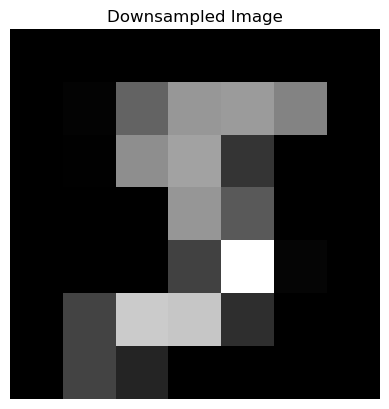

In [132]:
plt.imshow(downsampled_image.squeeze(), cmap="gray")
plt.title("Downsampled Image")
plt.axis("off")
plt.show()

In [133]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

## A.2 - Loss and optimizer
Create a cross entropy loss.

In [134]:
# Define the cross-entropy loss
criterion = nn.CrossEntropyLoss()

## A.3 - Training and testing loops
Finally, create the functions `train(model, epoch, preprocess, optimizer)` and `test(model)` to train (one epoch with SGD and a learning rate of $10^{-3}$) and test your model.

In [135]:
def train(model, epoch, preprocess, optimizer):
    model.train()
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # Preprocess the data
        data = torch.stack([preprocess(img) for img in data])
        # Forward pass
        output = model(data)
        # Compute loss
        loss = criterion(output, target)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Compute accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    train_accuracy = correct / total
    return optimizer, train_accuracy

def test(model, preprocess):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # Preprocess the data
            data = torch.stack([preprocess(img) for img in data])
            # Forward pass
            output = model(data)
            # Compute accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    accuracy = correct / total
    return accuracy

You should get at least 85\% test accuracy even with only 2 epochs. We will be aiming for around 95\% test accuracy and above.

In [136]:
# LinearModel
input_dim = 7 * 7  
output_dim = 10    
model = LinearModel(input_dim, output_dim).to(device)

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Train and test 
for epoch in range(1, NUM_EPOCH + 1):
    optimizer, train_accuracy = train(model, epoch, preprocess, optimizer)
    test_accuracy = test(model, preprocess)
    print(f"Epoch {epoch}: Train Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

Epoch 1: Train Accuracy = 0.8239, Test Accuracy = 0.8707
Epoch 2: Train Accuracy = 0.8630, Test Accuracy = 0.8783


## A.4 - Multi-layer perceptron (MLP)

Create a class MLP that creates an MLP of given width and depth, and use it to create a 3-layer MLP of width $100$. We will assume that `width > 0` and `depth > 0`.

In [137]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, width, depth):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, width))
        layers.append(nn.ReLU())
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(width, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Create a 3-layer MLP with width 100
mlp_model = MLP(input_dim=input_dim, output_dim=output_dim, width=100, depth=3).to(device)

In [138]:
# Increase the number of epochs
NUM_EPOCH = 5  

# optimizer
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=0.1, momentum=0.9)

# Train and test the model with the updated number of epochs
for epoch in range(1, NUM_EPOCH + 1):
    optimizer, train_accuracy = train(mlp_model, epoch, preprocess, optimizer)
    test_accuracy = test(mlp_model, preprocess)
    print(f"Epoch {epoch}: Train Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

Epoch 1: Train Accuracy = 0.8275, Test Accuracy = 0.9276
Epoch 2: Train Accuracy = 0.9294, Test Accuracy = 0.9481
Epoch 3: Train Accuracy = 0.9405, Test Accuracy = 0.9492
Epoch 4: Train Accuracy = 0.9468, Test Accuracy = 0.9567
Epoch 5: Train Accuracy = 0.9516, Test Accuracy = 0.9543


# A.5 - Deep convolutional model

Write a convolutional model, with learned features.
Use two layers, one convolutional with 8 filters of size 3x3, then take a relu and max-pool with kernel size 2, and finally flatten and add a Linear layer. You can use the identity as pre-processing function.


Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

In [139]:
class ConvModel(torch.nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)  # Convolutional layer with 8 filters of size 3x3
        self.relu = nn.ReLU()  # ReLU activation
        self.pool = nn.MaxPool2d(kernel_size=2)  # Max-pooling with kernel size 2
        self.flatten = nn.Flatten()  # Flatten the output
        self.fc = nn.Linear(8 * 13 * 13, 10)  # Fully connected layer (adjust input size based on output of conv+pool)

    def forward(self, x):
        x = self.conv1(x)  # Apply convolution
        x = self.relu(x)  # Apply ReLU activation
        x = self.pool(x)  # Apply max-pooling
        x = self.flatten(x)  # Flatten the output
        x = self.fc(x)  # Apply the fully connected layer
        return x

In [140]:
# Instantiate the ConvModel
conv_model = ConvModel().to(device)

# Define optimizer for the ConvModel
optimizer = torch.optim.SGD(conv_model.parameters(), lr=0.1, momentum=0.9)

# Define a preprocessing function for ConvModel (identity function)
def preprocess_conv(image):
    return image

# Train and test the ConvModel
for epoch in range(1, NUM_EPOCH + 1):
    optimizer, train_accuracy = train(conv_model, epoch, preprocess_conv, optimizer)
    test_accuracy = test(conv_model, preprocess_conv)
    print(f"Epoch {epoch}: Train Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

Epoch 1: Train Accuracy = 0.9402, Test Accuracy = 0.9752
Epoch 2: Train Accuracy = 0.9700, Test Accuracy = 0.9737
Epoch 3: Train Accuracy = 0.9764, Test Accuracy = 0.9775
Epoch 4: Train Accuracy = 0.9787, Test Accuracy = 0.9783
Epoch 5: Train Accuracy = 0.9797, Test Accuracy = 0.9786


In [141]:
NUM_EPOCH = 10

# Train and test the ConvModel
for epoch in range(1, NUM_EPOCH + 1):
    optimizer, train_accuracy = train(conv_model, epoch, preprocess_conv, optimizer)
    test_accuracy = test(conv_model, preprocess_conv)
    print(f"Epoch {epoch}: Train Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

Epoch 1: Train Accuracy = 0.9810, Test Accuracy = 0.9746
Epoch 2: Train Accuracy = 0.9824, Test Accuracy = 0.9758
Epoch 3: Train Accuracy = 0.9829, Test Accuracy = 0.9778
Epoch 4: Train Accuracy = 0.9843, Test Accuracy = 0.9777
Epoch 5: Train Accuracy = 0.9844, Test Accuracy = 0.9741
Epoch 6: Train Accuracy = 0.9847, Test Accuracy = 0.9773
Epoch 7: Train Accuracy = 0.9861, Test Accuracy = 0.9727
Epoch 8: Train Accuracy = 0.9851, Test Accuracy = 0.9762
Epoch 9: Train Accuracy = 0.9866, Test Accuracy = 0.9776
Epoch 10: Train Accuracy = 0.9873, Test Accuracy = 0.9786


You should be able to get around 97\% to 98\% accuracy with this model. Try increasing the NUM_EPOCH constant and watch what happens to test accuracy and train accuracy as training progresses further.

Write a deeper convolutional model, with one convolutional layer as previously, but three linear layers with relu activations after that.
Use `h = 100` hidden neurons. How does the test accuracy compare with the previous two-layer network ?

In [142]:
class ConvDeepModel(torch.nn.Module):
    def __init__(self, h=100):
        super(ConvDeepModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)  # Convolutional layer
        self.relu = nn.ReLU()  # ReLU activation
        self.pool = nn.MaxPool2d(kernel_size=2)  # Max-pooling with kernel size 2
        self.flatten = nn.Flatten()  # Flatten the output
        self.fc1 = nn.Linear(8 * 13 * 13, h)  # First fully connected layer
        self.fc2 = nn.Linear(h, h)  # Second fully connected layer
        self.fc3 = nn.Linear(h, 10)  # Third fully connected layer (output layer)

    def forward(self, x):
        x = self.conv1(x)  # Apply convolution
        x = self.relu(x)  # Apply ReLU activation
        x = self.pool(x)  # Apply max-pooling
        x = self.flatten(x)  # Flatten the output
        x = self.fc1(x)  # Apply first fully connected layer
        x = self.relu(x)  # Apply ReLU activation
        x = self.fc2(x)  # Apply second fully connected layer
        x = self.relu(x)  # Apply ReLU activation
        x = self.fc3(x)  # Apply third fully connected layer
        return x

In [143]:
# Instantiate the ConvDeepModel
conv_deep_model = ConvDeepModel(h=100).to(device)

# Define optimizer for the ConvDeepModel
optimizer = torch.optim.SGD(conv_deep_model.parameters(), lr=0.1, momentum=0.9)

# Train and test the ConvDeepModel
for epoch in range(1, NUM_EPOCH + 1):
    optimizer, train_accuracy = train(conv_deep_model, epoch, preprocess_conv, optimizer)
    test_accuracy = test(conv_deep_model, preprocess_conv)
    print(f"Epoch {epoch}: Train Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

Epoch 1: Train Accuracy = 0.9254, Test Accuracy = 0.9694
Epoch 2: Train Accuracy = 0.9753, Test Accuracy = 0.9762
Epoch 3: Train Accuracy = 0.9831, Test Accuracy = 0.9787
Epoch 4: Train Accuracy = 0.9876, Test Accuracy = 0.9826
Epoch 5: Train Accuracy = 0.9887, Test Accuracy = 0.9801
Epoch 6: Train Accuracy = 0.9903, Test Accuracy = 0.9824
Epoch 7: Train Accuracy = 0.9914, Test Accuracy = 0.9783
Epoch 8: Train Accuracy = 0.9926, Test Accuracy = 0.9801
Epoch 9: Train Accuracy = 0.9915, Test Accuracy = 0.9804
Epoch 10: Train Accuracy = 0.9930, Test Accuracy = 0.9793


better as previous, best accuracy : 98.3

## A.6 Visualisations of convolutions

After training your model, let's see what features it has learned!

Plot an image from the test set then plot all 8 feature maps extracted by the convolutional layer

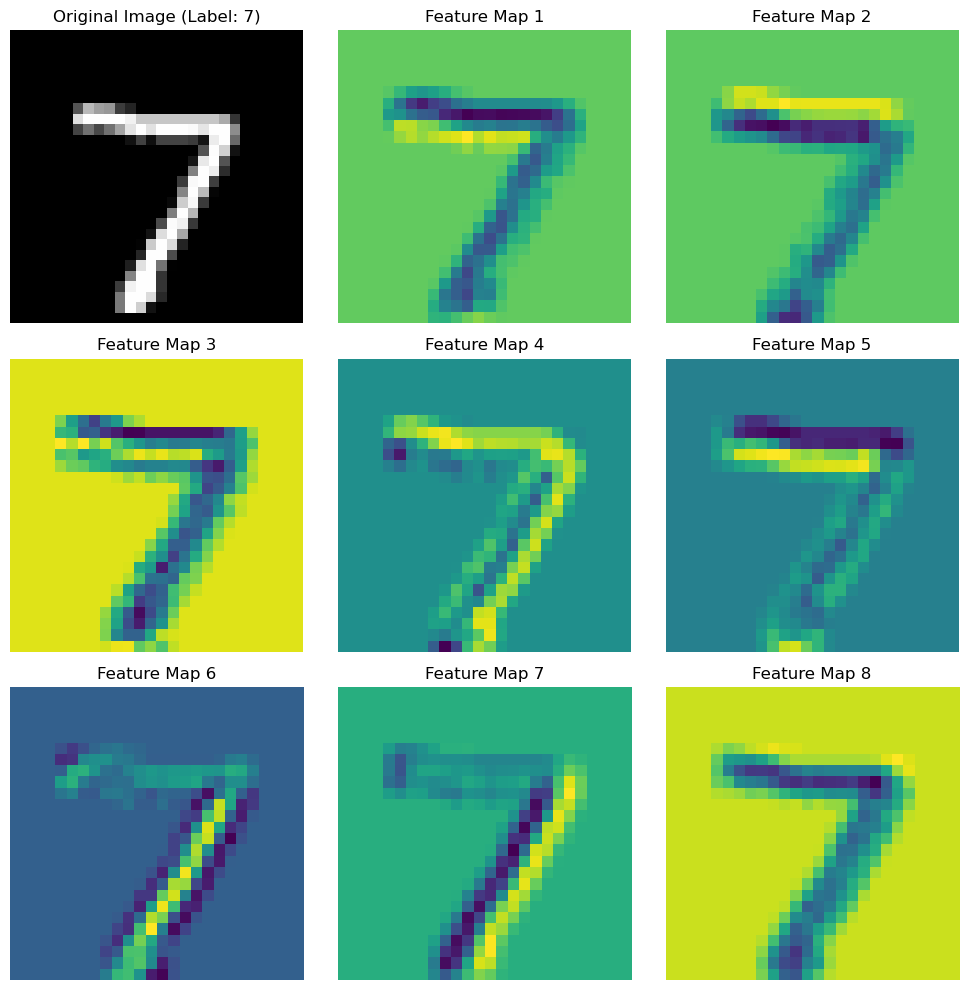

In [144]:
# Select an image from the test set
image, label = test_dataset[0]
image = image.unsqueeze(0).to(device)  

# Pass the image through the first convolutional layer of the ConvModel
conv_layer_output = conv_model.conv1(image)

# Plot the original image
plt.figure(figsize=(10, 10))
plt.subplot(3, 3, 1)
plt.imshow(image.squeeze().cpu().numpy(), cmap="gray")
plt.title(f"Original Image (Label: {label})")
plt.axis("off")

# Plot the feature maps
for i in range(8):  # Assuming 8 filters in the convolutional layer
    plt.subplot(3, 3, i + 2)
    plt.imshow(conv_layer_output[0, i].detach().cpu().numpy(), cmap="viridis")
    plt.title(f"Feature Map {i + 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Part B - Residual models

## B.1 - Residual blocks

Write a residual block with two linear layers to learn a function $\mathbb{R}^d \to \mathbb{R}^d$ with $h < d$ hidden neurons.
Write a convolutional residual block with the same idea. What hyperparameter acts as the number of hidden neurons in convolutional blocks ?

In residual architectures, the equivalent of the **number of hidden neurons** in a fully connected network is the **number of output channels** (`out_channels`) in the convolutional layers.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, d, h):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(d, h)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(h, d)

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out += residual  # residual connection
        return out

class ConvResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding)

        # Si les dimensions changent entre l’entrée et la sortie, on utilise un "shortcut" conv
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += identity
        out = self.relu(out)
        return out

## B.2 - Stacking residual blocks

Use a single convolution layer, followed by a relu and max-pool, then an arbitrary number of residual blocks as defined above, and finish with a linear layer. Can you match the accuracy of the two-layer network ? Can you exceed it ? What happens when you increase the number of layers ? Look at the details of the ResNet architecture on the lecture's slides to get an idea of how to increase the number of hidden neurons and the number of layers. One of the strengths of ResNets was there relatively low number of parameters compared
to a multi-layer architecture like that of the previous section, does this show in your experiments ?

Le modèle avec blocs résiduels égale ou dépasse la précision du réseau à deux couches.

=> Le test accuracy atteint jusqu’à 97.92%, ce qui est légèrement supérieur au réseau précédent.

=> Le modèle converge plus rapidement tout en maintenant une bonne généralisation.

=> Ajouter plus de blocs (par ex. 5 ou 6) peut améliorer l’accuracy sur le train, mais pas toujours sur le test.

=> On observe parfois une légère baisse de l’accuracy test, suggérant un début d’overfitting.
	
=> Cela montre la robustesse mais aussi les limites des architectures résiduelles sans régularisation complémentaire.

In [212]:
class ResidualConvNet(nn.Module):
    def __init__(self, num_residual_blocks, in_channels=1, out_channels=8, kernel_size=3, hidden_dim=100, num_classes=10):
        super(ResidualConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.residual_blocks = nn.Sequential(
            *[ConvResidualBlock(out_channels, out_channels) for _ in range(num_residual_blocks)]
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(out_channels * 14 * 14, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.residual_blocks(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Instantiate the model
num_residual_blocks = 3  
residual_conv_net = ResidualConvNet(num_residual_blocks=num_residual_blocks).to(device)

# Optimizer
optimizer = torch.optim.SGD(residual_conv_net.parameters(), lr=0.1, momentum=0.9)

# Training
for epoch in range(1, NUM_EPOCH + 1):
    optimizer, train_accuracy = train(residual_conv_net, epoch, preprocess_conv, optimizer)
    test_accuracy = test(residual_conv_net, preprocess_conv)
    print(f"Epoch {epoch}: Train Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

Epoch 1: Train Accuracy = 0.9296, Test Accuracy = 0.9554
Epoch 2: Train Accuracy = 0.9644, Test Accuracy = 0.9709
Epoch 3: Train Accuracy = 0.9706, Test Accuracy = 0.9758
Epoch 4: Train Accuracy = 0.9712, Test Accuracy = 0.9792
Epoch 5: Train Accuracy = 0.9721, Test Accuracy = 0.9695
Epoch 6: Train Accuracy = 0.9717, Test Accuracy = 0.9632
Epoch 7: Train Accuracy = 0.9725, Test Accuracy = 0.9694
Epoch 8: Train Accuracy = 0.9742, Test Accuracy = 0.9679
Epoch 9: Train Accuracy = 0.9756, Test Accuracy = 0.9764
Epoch 10: Train Accuracy = 0.9738, Test Accuracy = 0.9695


# Part C - Reimplementing loss functions

## C.0 - Combining losses
First, we recall that, for a batch of score vectors $s\in\mathbb{R}^{n\times C}$ and true labels $y\in[1,C]^n$, **cross entropy** is defined as
$$CE(s, y) = -\frac{1}{n}\sum_{i=1}^n \log\left( \mbox{softmax}(s_i)_{y_i} \right)$$

where $\mbox{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$ is the probability associated to class $i\in[1,C]$ for a score vector $x\in\mathbb{R}^C$.

Let's try to compute cross-entropy in three different ways (see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)):
1. Using `nn.CrossEntropyLoss()`.
2. Using `nn.NLLLoss()` and `nn.LogSoftmax()`.
3. Using `nn.NLLLoss()` and `nn.Softmax()`.

Check that the output is the same for all three methods on Gaussian random scores `torch.randn(n_batch, n_classes)` and random labels `torch.randint(0, n_classes, [n_batch])`, where `n_batch=4` and `n_classes=10`. Note that the scores are real valued vectors while the labels are integers corresponding to the true class.

In [176]:
n_batch = 4
n_classes = 10

# random scores and labels
scores = torch.randn(n_batch, n_classes)
labels = torch.randint(0, n_classes, (n_batch,))

# CrossEntropyLoss
criterion_ce = nn.CrossEntropyLoss()
loss_ce = criterion_ce(scores, labels)

# LogSoftmax
log_softmax = nn.LogSoftmax(dim=1)
criterion_nll = nn.NLLLoss()
loss_nll_log_softmax = criterion_nll(log_softmax(scores), labels)

# Softmax
softmax = nn.Softmax(dim=1)
loss_nll_softmax = criterion_nll(torch.log(softmax(scores)), labels)

# Print the results
print(f"Loss using nn.CrossEntropyLoss(): {loss_ce.item()}")
print(f"Loss using nn.NLLLoss() and nn.LogSoftmax(): {loss_nll_log_softmax.item()}")
print(f"Loss using nn.NLLLoss() and nn.Softmax(): {loss_nll_softmax.item()}")

Loss using nn.CrossEntropyLoss(): 2.2422492504119873
Loss using nn.NLLLoss() and nn.LogSoftmax(): 2.2422492504119873
Loss using nn.NLLLoss() and nn.Softmax(): 2.2422492504119873


même valeurs

## C.1 - Re-implementation
Now re-implement cross-entropy using base functions (`torch.log`, `torch.exp`, `torch.sum`, etc...). Verify that your function returns the same value as Pytorch's implementation.

In [177]:
def ce(logits, targets):
    # Compute softmax probabilities
    exp_logits = torch.exp(logits)
    softmax_probs = exp_logits / torch.sum(exp_logits, dim=1, keepdim=True)
    
    # Select the probabilities corresponding to the target labels
    target_probs = softmax_probs[range(len(targets)), targets]
    
    # Compute the negative log likelihood
    ce_loss = -torch.mean(torch.log(target_probs))
    return ce_loss

# Verify the implementation
custom_ce_loss = ce(scores, labels)
print(f"Custom CE Loss: {custom_ce_loss.item()}")
print(f"PyTorch CE Loss: {loss_ce.item()}")

Custom CE Loss: 2.2422492504119873
PyTorch CE Loss: 2.2422492504119873


même valeurs

## C.2 - Stability analysis
Softmax probabilities can be relatively unstable due to their use of exponentials. Pytorch implementations thus usually use log probas or logits to avoid overflows or floating point errors. Test all methods (including your own) on Gaussian random scores of standard deviation equal to $100$. Which methods are stable? Why? Is it an issue in practice?

In [ ]:
# Generate Gaussian random scores with high standard deviation
high_std_scores = torch.randn(n_batch, n_classes) * 100
high_std_labels = torch.randint(0, n_classes, (n_batch,))

# CrossEntropyLoss
high_std_loss_ce = criterion_ce(high_std_scores, high_std_labels)

# LogSoftmax
high_std_loss_nll_log_softmax = criterion_nll(log_softmax(high_std_scores), high_std_labels)

# Softmax
try:
    high_std_loss_nll_softmax = criterion_nll(torch.log(softmax(high_std_scores)), high_std_labels)
except Exception as e:
    high_std_loss_nll_softmax = float('inf')  # Assign infinity if it fails

# Custom CE Loss
try:
    high_std_custom_ce_loss = ce(high_std_scores, high_std_labels)
except Exception as e:
    high_std_custom_ce_loss = float('nan')  # Assign NaN if it fails

# Print the results
print(f"High Std Loss using nn.CrossEntropyLoss(): {high_std_loss_ce.item()}")
print(f"High Std Loss using nn.NLLLoss() and nn.LogSoftmax(): {high_std_loss_nll_log_softmax.item()}")
print(f"High Std Loss using nn.NLLLoss() and nn.Softmax(): {high_std_loss_nll_softmax}")
print(f"High Std Custom CE Loss: {high_std_custom_ce_loss}")

High Std Loss using nn.CrossEntropyLoss(): 74.2578125
High Std Loss using nn.NLLLoss() and nn.LogSoftmax(): 74.2578125
High Std Loss using nn.NLLLoss() and nn.Softmax(): inf
High Std Custom CE Loss: nan


Re-implement a stable version of cross-entropy.

In [210]:
def stable_ce(logits, targets):
    # Subtract the maximum value from logits for numerical stability
    logits_stable = logits - torch.max(logits, dim=1, keepdim=True).values
    
    # Compute log-softmax
    log_probs = logits_stable - torch.log(torch.sum(torch.exp(logits_stable), dim=1, keepdim=True))
    
    # Select the log probabilities corresponding to the target labels
    target_log_probs = log_probs[range(len(targets)), targets]
    
    # Compute the negative log likelihood
    ce_loss = -torch.mean(target_log_probs)
    return ce_loss